# Email Spam Detection with Machine Learning
## Sikotra Shivam

### Importing Dependencies

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,precision_score
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC


import string 
import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from wordcloud import WordCloud
from collections import Counter

### Importing Data

In [6]:
#Importing Data & Setting Column Names in same time removing extra null columns
df=pd.read_csv('./spam.csv',encoding='latin-1')
df=df.iloc[:,:-3]
df.rename(columns={'v1':'Category','v2':'Message'},inplace=True)

display(df.columns)
display(df.shape)

Index(['Category', 'Message'], dtype='object')

(5572, 2)


## Label Encoding 

In [7]:
#Labelling Spam as 0 & Ham as 1
# df=pd.get_dummies(df,columns=['Category'])
# df.loc[df['Category']=='spam']['Category']=0
# df.loc[df['Category']=='ham']['Category']=1

# Initializing Encoder
label_encoder = LabelEncoder()

df['Category'] = label_encoder.fit_transform(df['Category'])
df

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


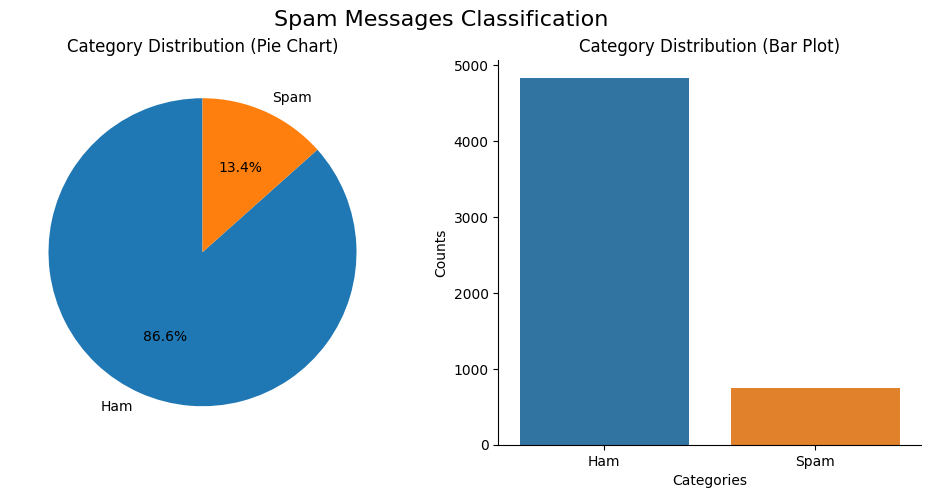

In [8]:
# Create subplots with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

counts=df['Category'].value_counts()

# Create a pie chart in the first subplot (ax[0])
ax[0].pie(counts, labels=['Ham', 'Spam'], autopct='%1.1f%%', startangle=90,wedgeprops=dict(width=1))
ax[0].set_title('Category Distribution (Pie Chart)')

# Create a bar plot in the second subplot (ax[1])
sns.barplot(x=['Ham', 'Spam'], y=counts, ax=ax[1])
ax[1].set_xlabel('Categories')
ax[1].set_ylabel('Counts')
ax[1].set_title('Category Distribution (Bar Plot)')

# Hide spines on both subplots
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.suptitle('Spam Messages Classification', fontsize=16)
plt.show()


In [9]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Shivam
[nltk_data]     Sikotra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Shivam
[nltk_data]     Sikotra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
df['Num_Chars'] = df['Message'].apply(len)
df.head()


,Category,Message,Num_Chars
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [11]:
df['Num_Words'] = df['Message'].apply(lambda x : len(nltk.word_tokenize(x)))
df.head()

,Category,Message,Num_Chars,Num_Words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [12]:
df['Num_Sents'] = df['Message'].apply(lambda x : len(nltk.sent_tokenize(x)))
df.head()

,Category,Message,Num_Chars,Num_Words,Num_Sents
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [13]:
# for Ham
df.query('Category==0')[['Num_Chars','Num_Words','Num_Sents']].describe()

,Num_Chars,Num_Words,Num_Sents
count,4825.000000,4825.000000,4825.000000
mean,71.023627,17.276269,1.837720
std,58.016023,13.988585,1.454388
min,2.000000,1.000000,1.000000
25%,33.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,92.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [14]:
# for Spam
df.query('Category==1')[['Num_Chars','Num_Words','Num_Sents']].describe()

,Num_Chars,Num_Words,Num_Sents
count,747.000000,747.000000,747.000000
mean,138.866131,27.891566,3.021419
std,29.183082,6.867007,1.537580
min,13.000000,2.000000,1.000000
25%,132.500000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


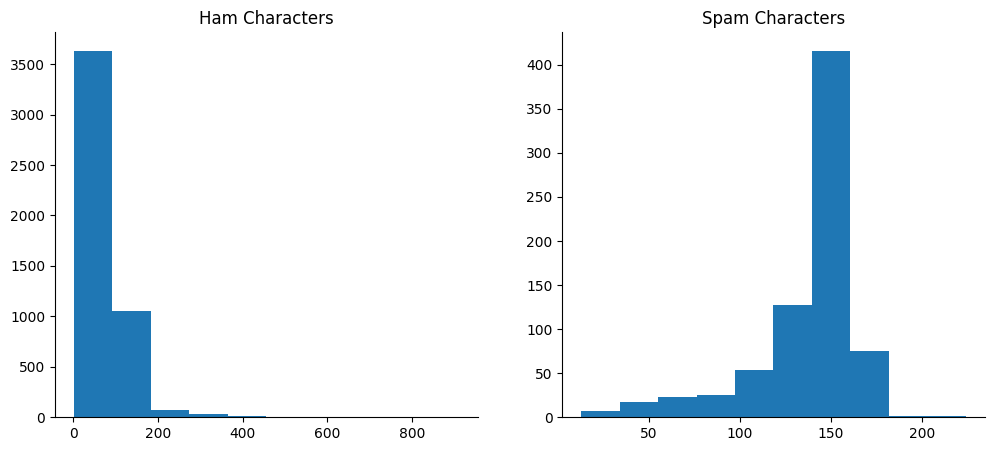

In [15]:
fig,ax=plt.subplots(1,2, figsize=(12, 5))
ax[0].hist(df[df['Category']==0]['Num_Chars'])
ax[0].set_title('Ham Characters')
ax[1].hist(df[df['Category']==1]['Num_Chars'])
ax[1].set_title('Spam Characters')

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

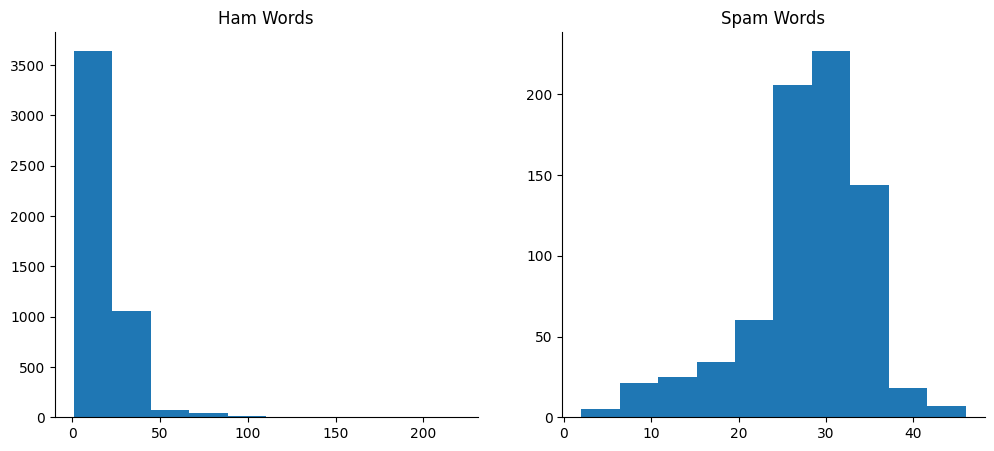

In [16]:
fig,ax=plt.subplots(1,2, figsize=(12, 5))
ax[0].hist(df[df['Category']==0]['Num_Words'])
ax[0].set_title('Ham Words')
ax[1].hist(df[df['Category']==1]['Num_Words'])
ax[1].set_title('Spam Words')

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

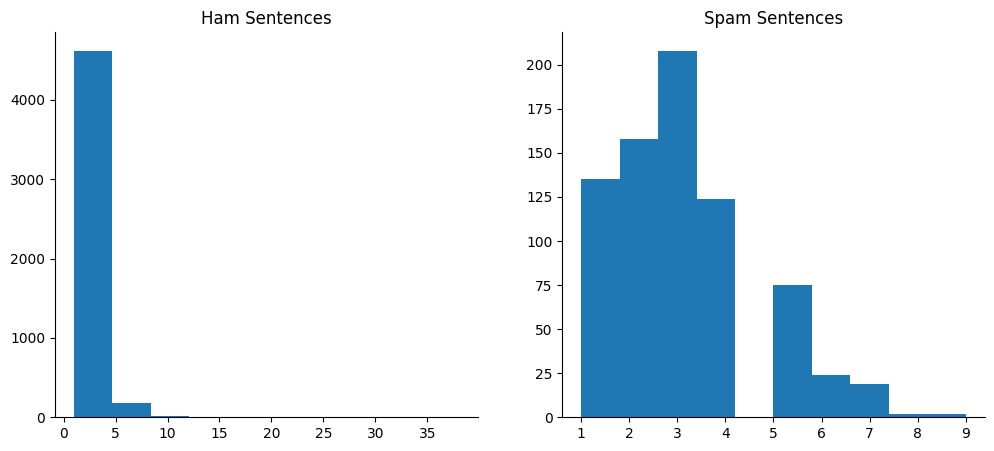

In [17]:
fig,ax=plt.subplots(1,2, figsize=(12, 5))
ax[0].hist(df[df['Category']==0]['Num_Sents'])
ax[0].set_title('Ham Sentences')
ax[1].hist(df[df['Category']==1]['Num_Sents'])
ax[1].set_title('Spam Sentences')

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

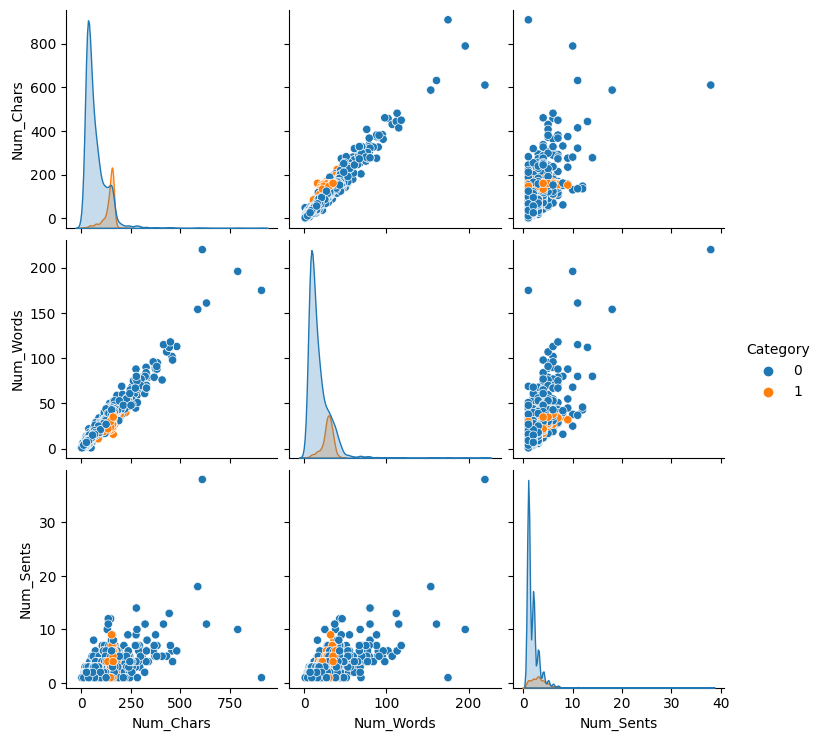

In [18]:
sns.pairplot(df,hue='Category')

<Axes: >

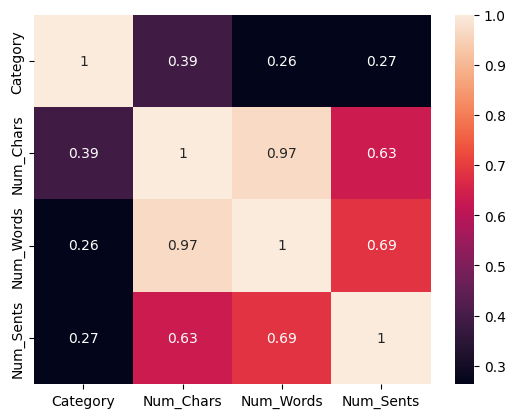

In [19]:
correlation=df[['Category','Num_Chars','Num_Words','Num_Sents']].corr()

sns.heatmap(correlation,annot=True)
# df

## Data Preprocessing
+  Lowecase
+  Tokenizing
+  Removing Special Characters
+  Removing Stop words and punctuations
+  Stemming

In [20]:
stop_words = set(stopwords.words('english'))

In [21]:
puncts=set(string.punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [22]:
ps=PorterStemmer()

In [23]:

def transform(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y=[]
    
    for i in text:
        if i.isalnum() and i not in stop_words and i not in puncts:
            y.append(i)
    
    text=y[:]
    y=[]
    
    for i in text:
        y.append(ps.stem(i))
    
    return ' '.join(y)
transform('I loved Yt LecTures On Machine Learning !!!!')

'love yt lectur machin learn'

In [24]:
df['Transform_Text'] = df['Message'].apply(transform)
df.head()

,Category,Message,Num_Chars,Num_Words,Num_Sents,Transform_Text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [25]:
wc=WordCloud(width=600,height=600,min_font_size=10,background_color='black')

In [26]:
spam_wc = wc.generate(df[df['Category']==1]['Transform_Text'].str.cat(sep=" "))

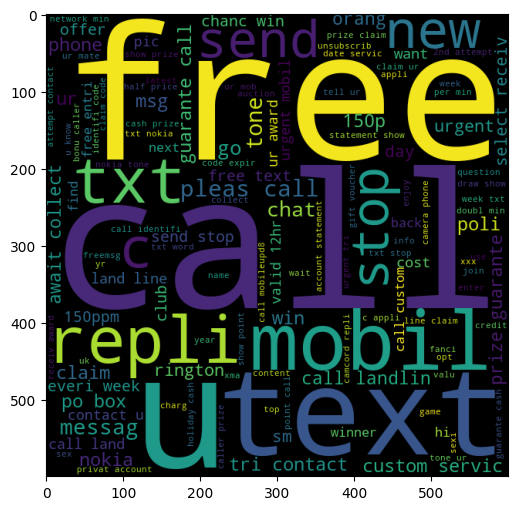

In [27]:
plt.figure(figsize=(12,6))
plt.imshow(spam_wc)

In [28]:
ham_wc = wc.generate(df[df['Category']==0]['Transform_Text'].str.cat(sep=" "))

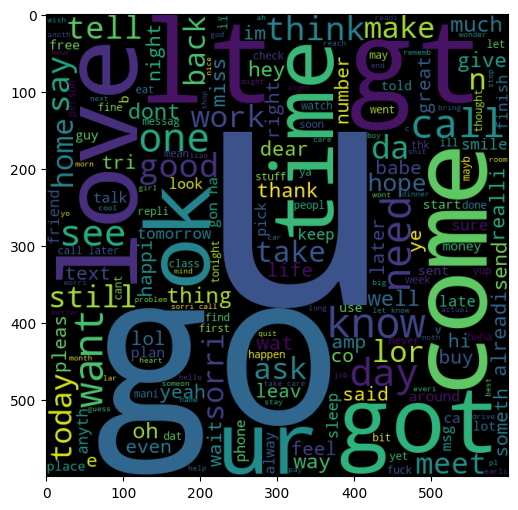

In [29]:
plt.figure(figsize=(12,6))
plt.imshow(ham_wc)

In [30]:
# Counting Top 30 words in Spam Messages
spam_corpus=[]
for msg in df[df['Category']==1]['Transform_Text']:
    for word in msg.split():
        spam_corpus.append(word)

In [31]:
# Counting Top 30 words in Spam Messages
ham_corpus=[]
for msg in df[df['Category']==0]['Transform_Text']:
    for word in msg.split():
        ham_corpus.append(word)

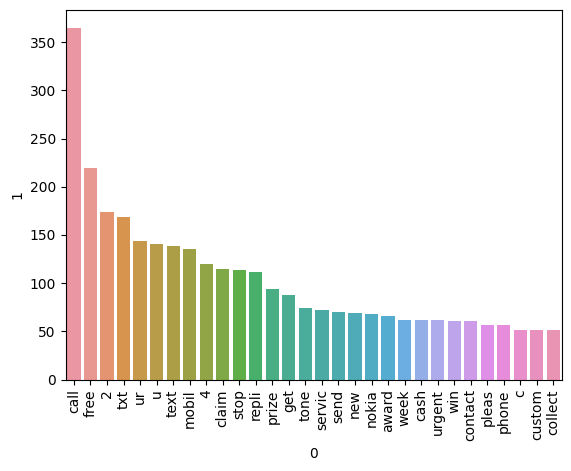

In [32]:
df_sc = pd.DataFrame(Counter(spam_corpus).most_common(30))
sns.barplot(x=df_sc[0],y=df_sc[1])
plt.xticks(rotation=90)
plt.show()


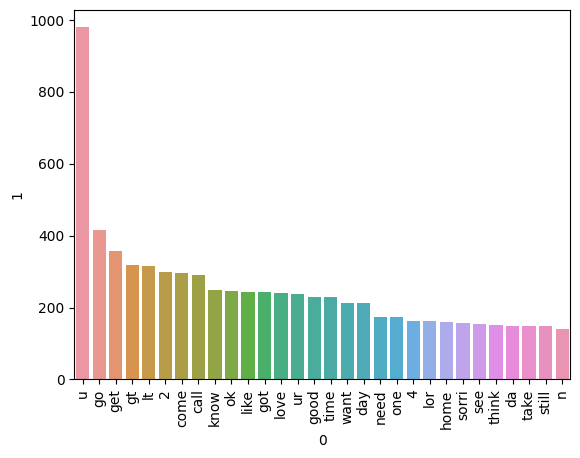

In [33]:
df_sc = pd.DataFrame(Counter(ham_corpus).most_common(30))
sns.barplot(x=df_sc[0],y=df_sc[1])
plt.xticks(rotation=90)
plt.show()


## Model Building

In [34]:
# We  now have to convert messages to Word Vectors
cv=CountVectorizer()
tfidf=TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['Transform_Text']).toarray()
X.shape

(5572, 3000)

In [35]:
y=df['Category'].values
y

array([0, 0, 1, ..., 0, 0, 0])

### Spilitting data into Test , Train set

In [36]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print(X.shape,y.shape)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(5572, 3000) (5572,)
(4457, 3000) (4457,)
(1115, 3000) (1115,)


### Naive Bayes Model

In [37]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()


In [38]:
gnb.fit(X_train,y_train)
gnb_pred = gnb.predict(X_test)
print(accuracy_score(y_test,gnb_pred))
print(confusion_matrix(y_test,gnb_pred))
print(precision_score(y_test,gnb_pred))

0.8771300448430494
[[847 119]
 [ 18 131]]
0.524


In [39]:
mnb.fit(X_train,y_train)
mnb_pred = mnb.predict(X_test)
print(accuracy_score(y_test,mnb_pred))
print(confusion_matrix(y_test,mnb_pred))
print(precision_score(y_test,mnb_pred))

0.9757847533632287
[[965   1]
 [ 26 123]]
0.9919354838709677


In [40]:
bnb.fit(X_train,y_train)
bnb_pred = bnb.predict(X_test)
print(accuracy_score(y_test,bnb_pred))
print(confusion_matrix(y_test,bnb_pred))
print(precision_score(y_test,bnb_pred))

0.9802690582959641
[[962   4]
 [ 18 131]]
0.9703703703703703


As Data Imbalance is there Accuracy not matters much what matters is Precision_Score
Multinomail gives max Precision_Score so we try to take that

In [41]:
svc = SVC(kernel='sigmoid', gamma=1.0)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

In [42]:
# Applying stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [47]:
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9757847533632287
Precision 0.9919354838709677
